# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lab 02 - Bayesian Analysis 

**Harvard University**<br>
**Spring 2022**<br>
**Instructors:** Mark Glickman and Pavlos Protopapas<br>
**Lab instructor and content:** Eleni Angelaki Kaxiras<br>

---

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

from pymc3 import summary

warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.stats as stats
import pandas as pd
import seaborn as sns
%matplotlib inline 

import warnings
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.11.4


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 20000;

<IPython.core.display.Javascript object>

In [3]:
#pandas trick
pd.options.display.max_columns = 50  # None -> No Restrictions
pd.options.display.max_rows = 200    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

## Learning Objectives

By the end of this lab, you should be able to:
* Define a probabilistic model in the PyMC3 framework
* Run a sampling algorithm 

**This lab corresponds to Lectures 3,4, and maps to Homework 2.**

## 1. Bayes Rule

We have data that we believe come from an underlying distribution of unknown parameters. If we find those parameters, we know everything about the process that generated these data and we can make inferences or create new data.

\begin{equation}
\label{eq:bayes} 
P(\theta|\textbf{D}) = \frac{P(\theta) P(\textbf{D}|\theta)}{P(\textbf{D})} 
\end{equation}

$P(\theta|\textbf{D})$ is the **posterior** distribution, prob(hypothesis | data) 

$P(\textbf{D} |\theta)$ is the **likelihood** function, how probable is my data **D** for different values of the parameters

$P(\theta)$ is the marginal probability to observe the data, called the **prior**, this captures our belief about the data before observing it.

$P(\textbf{D})$ is the marginal distribution (sometimes called marginal likelihood)

#### But what is $\theta \;$?

$\theta$ is an unknown yet fixed set of parameters. In Bayesian inference we express our belief about what $\theta$ might be and instead of trying to guess $\theta$ exactly, we look for its **probability distribution**. What that means is that we are looking for the **parameters** of that distribution. For example, for a Poisson distribution our $\theta$ is only $\lambda$. In a normal distribution, our $\theta$ is often just $\mu$ and $\sigma$.

<a id=pymc3></a> [Top](#top)

## 2. Introduction to `pyMC3`
 
PyMC3 is a Python library for programming Bayesian analysis, and more specifically, data creation, model definition, model fitting, and posterior analysis. It uses the concept of a `model` which contains assigned parametric statistical distributions to unknown quantities in the model. Within models we define random variables and their distributions. A distribution requires at least a `name` argument, and other `parameters` that define it. You may also use the `logp()` method in the model to build the model log-likelihood function. We define and fit the model.

PyMC3 includes a comprehensive set of pre-defined statistical distributions that can be used as model building blocks. Although they are not meant to be used outside of a `model`, you can invoke them by using the prefix `pm`, as in `pm.Normal`. To use them outside of a model one needs to invoke them as `pm.Normal.dist()`.

## 3. Probability distributions in `scipy` and `PyMC3`

We can invoke probability distributions from `scipy` or directly from `PyMC3`. Distributions in `PyMC3` live within the context of models, although the framework provides a way to use the distributions outside of models. For a review of most common discete and continuous distributions see separate notebook.

### `scipy`
 
- **Normal** (a.k.a. Gaussian)
\begin{equation}
X \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

    A Normal distribution can be parameterized either in terms of precision $\tau$ or variance $\sigma^{2}$. The link between the two is given by
\begin{equation}
\tau = \frac{1}{\sigma^{2}}
\end{equation}
 - Expected value (mean) $\mu$
 - Variance $\frac{1}{\tau}$ or $\sigma^{2}$
 - Parameters: `mu: float`, `sigma: float` or `tau: float`
 - Range of values (-$\infty$, $\infty$)

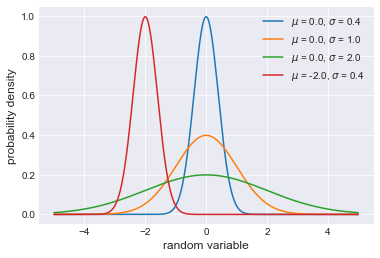

In [4]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(-5, 5, 1000)
mus = [0., 0., 0., -2.]
sigmas = [0.4, 1., 2., 0.4]
for mu, sigma in zip(mus, sigmas):
    pdf = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, pdf, label=r'$\mu$ = '+ f'{mu}, ' + r'$\sigma$ = ' + f'{sigma}') 
plt.xlabel('random variable', fontsize=12)
plt.ylabel('probability density', fontsize=12)
plt.legend(loc=1)
plt.show()

### `PyMC3`

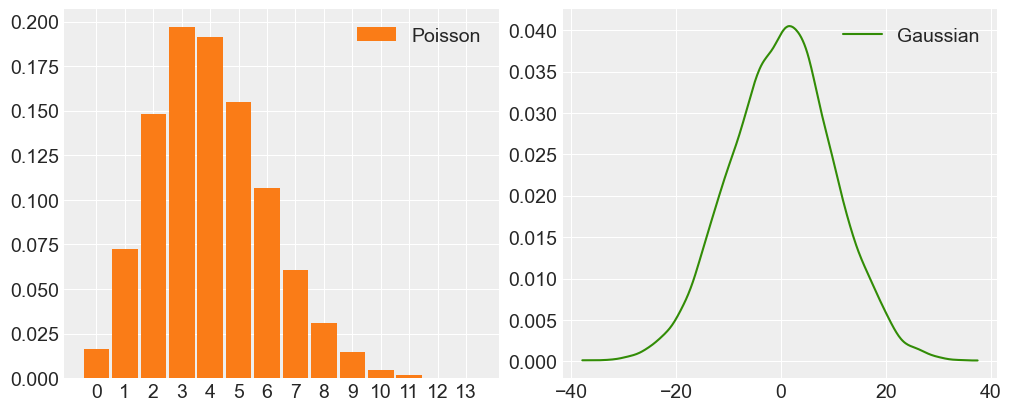

In [5]:
az.style.use("arviz-darkgrid")

a = pm.Poisson.dist(mu=4)
b = pm.Normal.dist(mu=0, sigma=10)

_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_dist(a.random(size=10000), color="C1", label="Poisson", ax=ax[0])
az.plot_dist(b.random(size=10000), color="C2", label="Gaussian", ax=ax[1])

plt.show()

In [6]:
float(pm.Normal.dist(mu=0, sigma = 10).random(size = 1))

2.2306996947087843

- [Distributions in PyMC3](https://docs.pymc.io/api/distributions.html)

Information about PyMC3 functions including descriptions of distributions, sampling methods, and other functions, is available via the `help` command.

In [7]:
## uncomment to look at the documentation 
# help(pm.Poisson)

<a id=blr></a> [Top](#top)

## 3. Bayesian Linear Regression

#### Define the Problem

Our problem is the following: we want to perform multiple linear regression to predict an outcome variable $Y$ which depends on variables $\bf{x}_1$ and $\bf{x}_2$.

We will model $Y$ as normally distributed observations with an expected value $mu$ that is a linear function of the two predictor variables, $\bf{x}_1$ and $\bf{x}_2$.

\begin{equation}
Y \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

\begin{equation}
\mu = \beta_0 + \beta_1 \bf{x}_1 + \beta_2 x_2 
\end{equation}

where $\sigma^2$ represents the measurement error (in this example, we will use $\sigma = 10$). **Note:** In the code we give the value for the standard deviation $\sigma$.

We also choose the parameters to have normal distributions with those parameters set by us.

\begin{eqnarray}
\beta_i \sim  \mathcal{N}(0,\,10) \\
\sigma^2 \sim  |\mathcal{N}(0,\,10)|
\end{eqnarray}   
We will artificially create the data to predict on. We will then see if our model predicts them correctly.

#### Artificially create some data to test our model.

In [8]:
np.random.seed(123)

# True parameter values < --- our model does not see these
sigma = 1
beta0 = 1 # intercept

# beta1 and beta2
beta = [1, 2.5]  

# Size of dataset
size = 100

# Predictor variable
x1 = np.linspace(0, 1., size)
x2 = np.linspace(0,2., size)

# Simulate outcome variable
Y = beta0 + beta[0]*x1 + beta[1]*x2 + np.random.randn(size) * sigma

C:\Users\zzlzh\AppData\Local\Temp\ipykernel_40808\735757316.py:16: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=.1, w_pad=10.1, h_pad=2.)


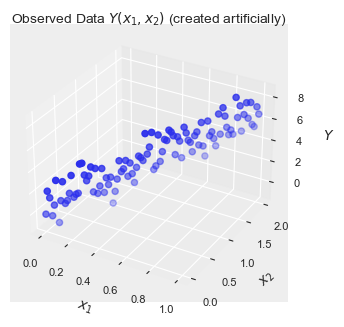

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(4,3))
fontsize=10
labelsize=8
title='Observed Data ' + r'$Y(x_1,x_2)$' + ' (created artificially)'
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, Y)
ax.set_xlabel(r'$x_1$', fontsize=fontsize)
ax.set_ylabel(r'$x_2$', fontsize=fontsize)
ax.set_zlabel(r'$Y$', fontsize=fontsize)

ax.tick_params(labelsize=labelsize)

fig.suptitle(title, fontsize=fontsize)        
fig.tight_layout(pad=.1, w_pad=10.1, h_pad=2.)
#fig.subplots_adjust(); #top=0.5
plt.tight_layout
plt.show()

Now let's see if our model will correctly predict the values for our unknown parameters, namely $b_0$, $b_1$, $b_2$ and $\sigma$.

#### Define the Model in PyMC3

In [10]:
from pymc3 import Model, Normal, HalfNormal, model_to_graphviz
from pymc3 import NUTS, sample, find_MAP
from scipy import optimize

**Step1:** Formulate the probability model for our data: $Y \sim  \mathcal{N}(\mu,\,\sigma^{2})$. This the **likelihood function** and it's defined the same as the other distributions except that there is an `observed` argument which means its values are determined by the data.

```
Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
```

**Step2:** Choose a prior distribution for our unknown parameters. 
```
 beta0 = Normal('beta0', mu=0, sigma=10)
 
 # Note: betas is a vector of two variables, b1 and b2, (denoted by shape=2)
 # so, in array notation, our beta1 = betas[0], and beta2=betas[1]
 betas = Normal('betas', mu=0, sigma=10, shape=2) 
 
 sigma = HalfNormal('sigma', sigma=1)

```

**Step3:** Determine the posterior distribution, **this is our main goal**.

**Step4:** Summarize important features of the posterior and/or plot the parameters.

In [11]:
with Model() as my_linear_model:

    # Priors for unknown model parameters, specifically created stochastic random variables 
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations.
    # These are our parameters.
    
    beta0 = Normal('beta0', mu=0, sd=1)
    # Note: betas is a vector of two variables, b1 and b2, (denoted by shape=2)
    # so, in array notation, our beta1 = betas[0], and beta2=betas[1]
    betas = Normal('betas', mu=0, sd=1, shape=2) 
    sigma = HalfNormal('sigma', sd=1)
    
    # mu is what is called a deterministic random variable, which implies that its value is completely
    # determined by its parents’ values (betas and sigma in our case). 
    # There is no uncertainty in the variable beyond that which is inherent in the parents’ values
    
    mu = beta0 + betas[0]*x1 + betas[1]*x2
    
    # Likelihood function = how probable is my observed data?
    # This is a special case of a stochastic variable that we call an observed stochastic.
    # It is identical to a standard stochastic, except that its observed argument, 
    # which passes the data to the variable, indicates that the values for this variable were observed, 
    # and should not be changed by any fitting algorithm applied to the model. 
    # The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.
    
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Note: If our problem was a classification for which we would use Logistic regression see [below](#LR) 

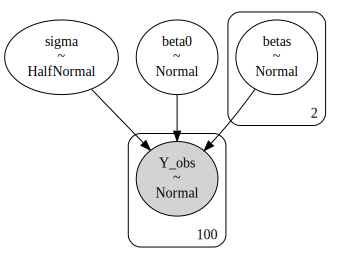

In [12]:
model_to_graphviz(my_linear_model)

#### Markov Chain Monte Carlo (MCMC) Simulations

PyMC3 uses the **No-U-Turn Sampler (NUTS)** and the **Random Walk Metropolis**, two Markov chain Monte Carlo (MCMC) algorithms for sampling in posterior space. Monte Carlo gets into the name because when we sample in posterior space, we choose our next move via a pseudo-random process. NUTS is a sophisticated algorithm that can handle a large number of unknown (albeit continuous) variables.

#### Fitting the Model with Sampling - Doing Inference

See below for PyMC3's sampling method. As you can see it has quite a few parameters. Most of them are set to default values by the package. For some, it's useful to set your own values.
```
pymc3.sampling.sample(draws=500, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, cores=None, tune=500, progressbar=True, model=None, random_seed=None, discard_tuned_samples=True, compute_convergence_checks=True, **kwargs)
```

Parameters to set:

- **draws** (int): number of samples to draw, defaults to 500. 
- **step** (MCMC method): implementation method for MCMC. Better to let pyMC3 assign the best one. If manually setting we can choose between some implementations such as `Metropolis()` or `NUTS()`.
- **tune** (int): number of iterations to tune for, a.k.a. the "burn-in" period, defaults to 500. 
- **target_accept** (float in $[0, 1]$). The step size is tuned such that we approximate this acceptance rate. Higher values like 0.9 or 0.95 often work better for problematic posteriors.
- (optional) **cores** (int) number of chains to run in parallel, defaults to the number of CPUs in the system, but at most 4.

`pm.sample` returns a `pymc3.backends.base.MultiTrace` object that contains the samples. We usually name it `trace`. All the information about the posterior is in `trace`, which also provides statistics about the sampler.

In [13]:
## uncomment this to see more about pm.sample
#help(pm.sample)

#### Specify a `NUTS()` sampler

It is the default and we expect good results.

In [14]:
with my_linear_model:
 
    print(f'Starting MCMC process')
    # draw 2000 posterior samples and run the default number of chains = 4
    # total number of samples = 2000 + 1000 = 3000
    trace = sample(2000, tune=1000, chains = 2, target_accept=0.95, cores = 5) 
    print(f'DONE')

Starting MCMC process


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 5 jobs)
NUTS: [sigma, betas, beta0]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.


DONE


Got error No model on context stack. trying to find log_likelihood in translation.


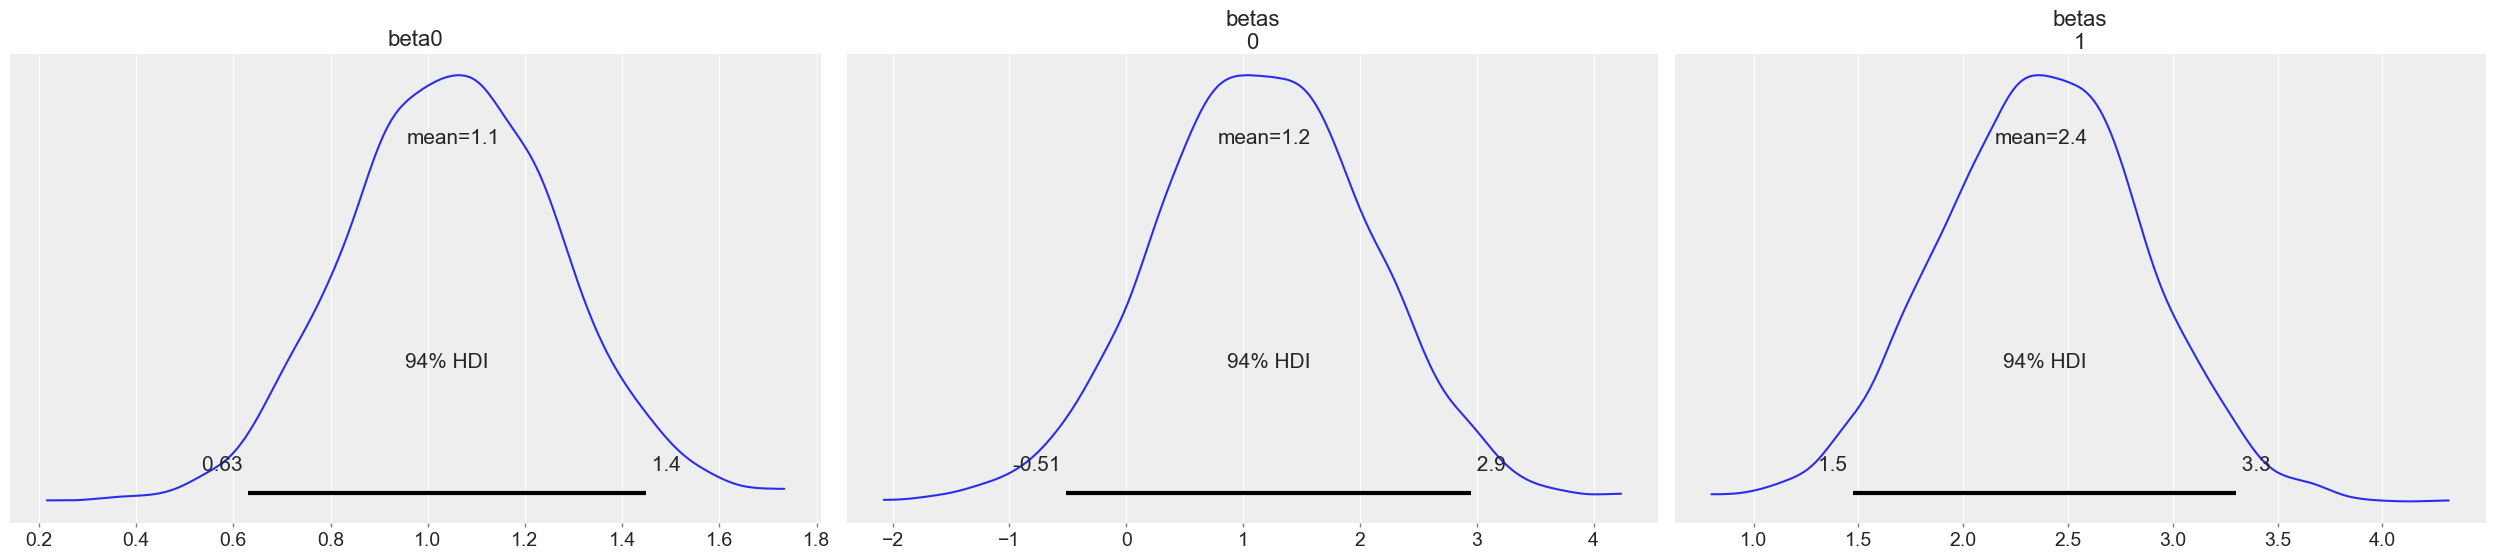

In [15]:
az.plot_posterior(trace, var_names=['beta0', 'betas']);

Got error No model on context stack. trying to find log_likelihood in translation.


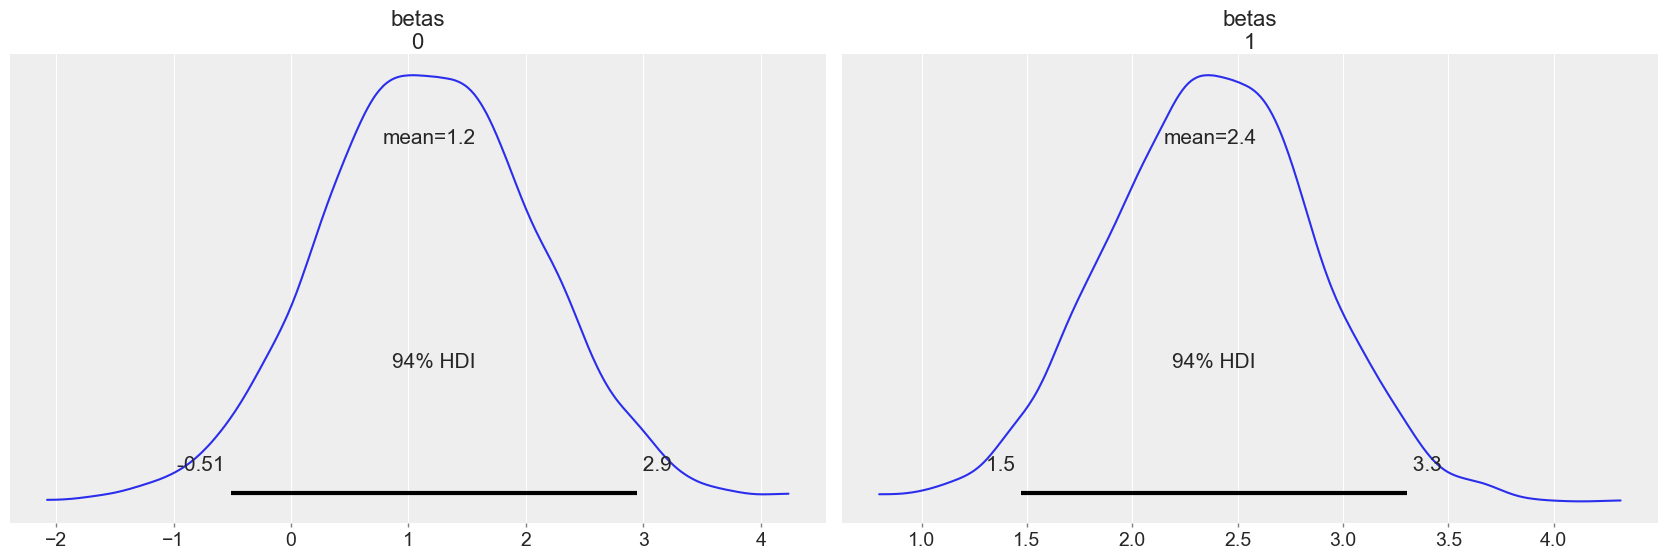

In [16]:
az.plot_posterior(trace, var_names=['betas']);

Got error No model on context stack. trying to find log_likelihood in translation.


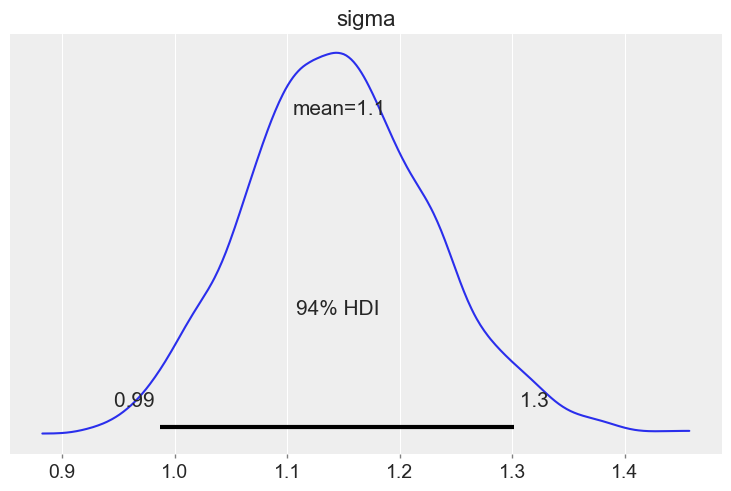

In [17]:
az.plot_posterior(trace, var_names=['sigma']);

Let's compare with the true hidden parameter values <br>
sigma = 1, beta0 = 1 , beta = [1, 2.5] 

C:\Users\zzlzh\AppData\Local\Temp\ipykernel_40808\480544983.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(trace);
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


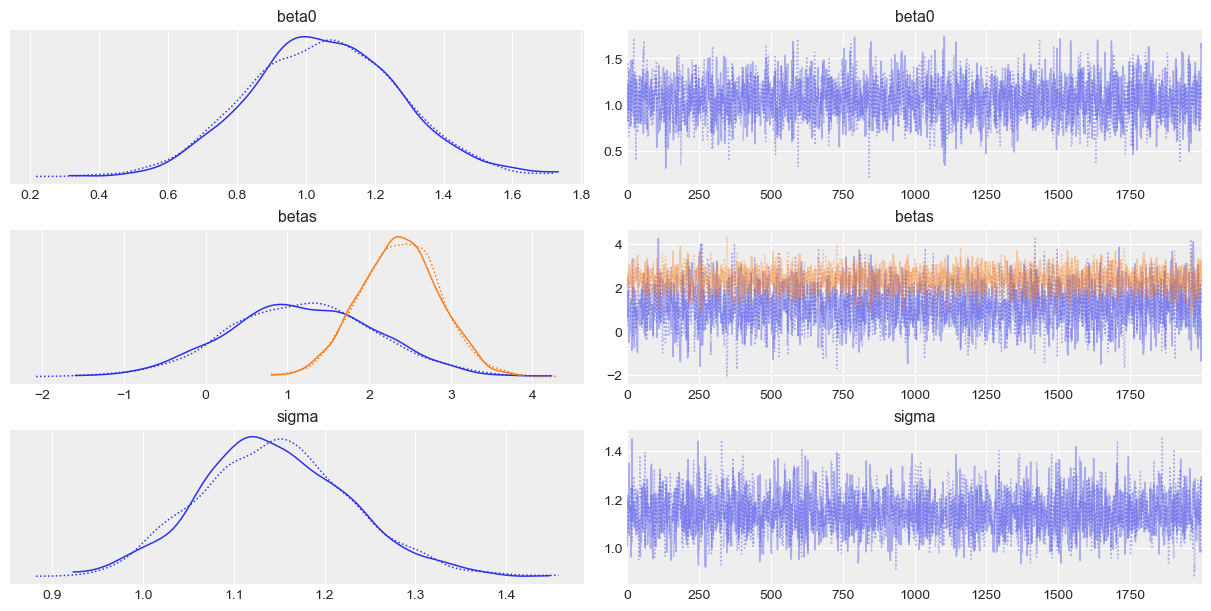

In [18]:
from pymc3 import traceplot, compareplot, plot_posterior, forestplot
traceplot(trace);

$\hat{R}$ is a metric for comparing how well a chain has converged to the equilibrium distribution by comparing its behavior to other randomly initialized Markov chains. Multiple chains initialized from different initial conditions should give similar results.
If all chains converge to the same equilibrium, $\hat{R}$ will be 1. If the chains have not converged to a common distribution, $\hat{R}$ will be > 1.01. $\hat{R}$ is a necessary but not sufficient condition.

For details on the $\hat{R}$ see *Gelman and Rubin (1992)*. 

In [19]:
pm.rhat(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


<xarray.Dataset>
Dimensions:      (betas_dim_0: 2)
Coordinates:
  * betas_dim_0  (betas_dim_0) int32 0 1
Data variables:
    beta0        float64 1.0
    betas        (betas_dim_0) float64 0.9999 0.9999
    sigma        float64 1.0

C:\Users\zzlzh\AppData\Local\Temp\ipykernel_40808\300367496.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  forestplot(trace, var_names=['beta0', 'betas', 'sigma'], r_hat=True);
Got error No model on context stack. trying to find log_likelihood in translation.


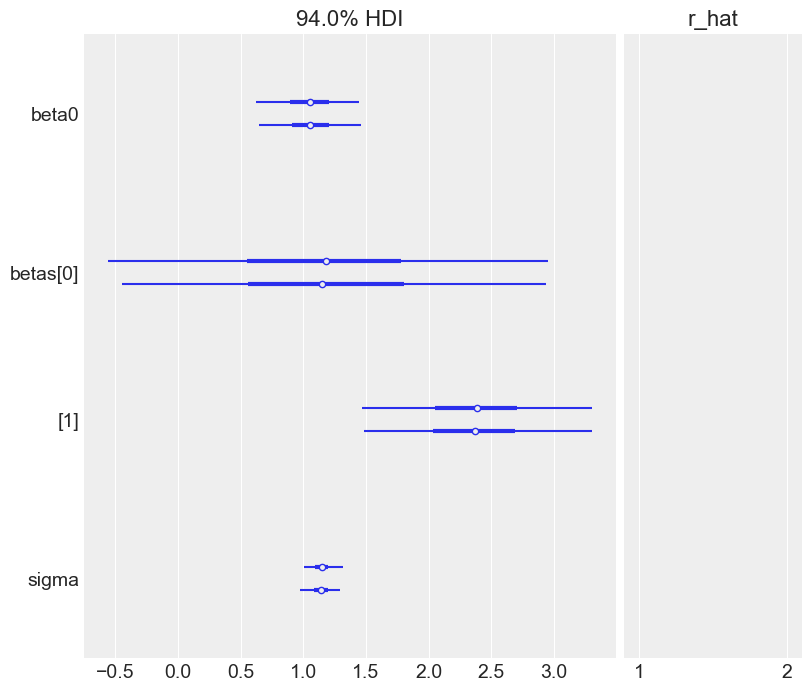

In [20]:
forestplot(trace, var_names=['beta0', 'betas', 'sigma'], r_hat=True);

#### Specify a `Metropolis()` sampler

We do not expect good results.

In [21]:
#help(pm.backends.base.MultiTrace)

In [22]:
with my_linear_model:
 
    print(f'Starting MCMC process')
    # draw 2000 posterior samples and run the default number of chains = 4 
    trace = sample(2000, step=pm.Metropolis(), tune=1000) #, target_accept=0.9) 
    print(f'DONE')

Starting MCMC process


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [betas]
>Metropolis: [beta0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


DONE


C:\Users\zzlzh\AppData\Local\Temp\ipykernel_40808\480544983.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(trace);
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


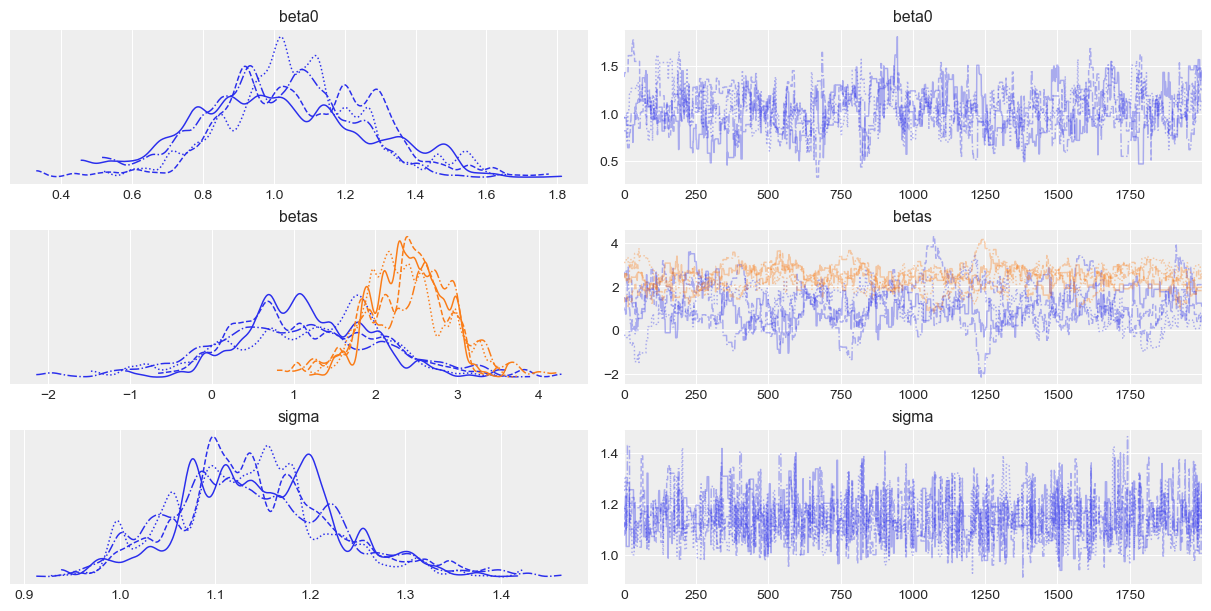

In [23]:
from pymc3 import traceplot, compareplot, plot_posterior, forestplot
traceplot(trace);

#### Model Plotting

PyMC3 provides a variety of visualizations via plots: [https://docs.pymc.io/api/plots.html](https://docs.pymc.io/api/plots.html).

One of them is the `traceplot`, another is the `compareplot`. 

Got error No model on context stack. trying to find log_likelihood in translation.


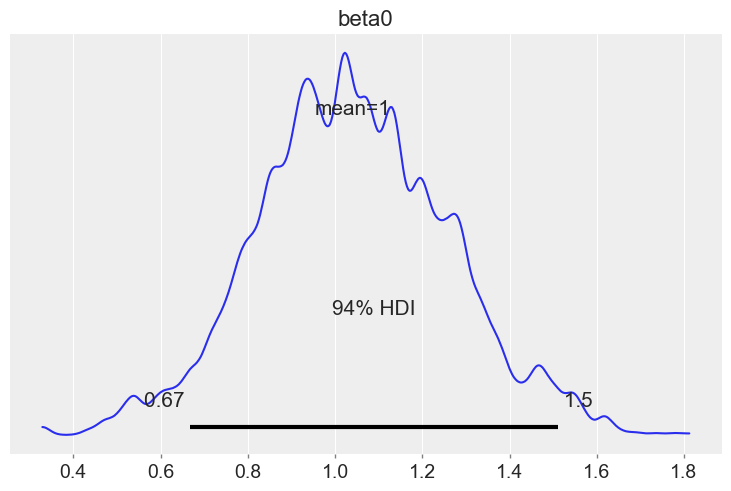

In [24]:
az.plot_posterior(trace, var_names=['beta0']);

In [25]:
#help(az.plot_posterior)

In [26]:
#help(pm.Normal)

In [27]:
# Then we will generate and display our table
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.040,0.219,0.668,1.511,0.015,0.011,205.0,316.0,1.03
betas[0],1.141,0.921,-0.583,2.839,0.103,0.073,81.0,148.0,1.02
betas[1],2.401,0.493,1.500,3.313,0.052,0.037,91.0,150.0,1.02
sigma,1.142,0.083,0.993,1.307,0.003,0.002,984.0,918.0,1.01


In [28]:
trace.varnames

['beta0', 'betas', 'sigma_log__', 'sigma']

In [29]:
#help(pm.backends.base.MultiTrace)

This linear regression example is from the original paper on PyMC3: *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55*

<a id=LR></a>

### What about Logistic Regression?

If the problem above was a classification that required a Logistic Regression, we would use the logistic function ( where $\beta_0$ is the intercept, and $\beta_i$ (i=1, 2, 3) determines the shape of the logistic function).

\begin{equation}
Pr(Y=1|X_1,X_2,X3) = {\frac{1}{1 + exp^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3)}}}
\end{equation}

Since both $\beta_0$ and the $\beta_i$s can be any possitive or negative number, we can model them as gaussian random variables.

\begin{eqnarray}
\beta_0 \sim  \mathcal{N}(\mu,\,\sigma^2) \\
\beta_i \sim  \mathcal{N}(\mu_i,\,\sigma_i^2)
\end{eqnarray} 

In PyMC3 we can model those as:
```
pm.Normal('beta_0', mu=0, sigma=100)
```
(where $\mu$ and $\sigma^2$ can have some initial values that we assign them, e.g. 0 and 100)

The dererministic variable would be:
```
p-logit = beta0 + beta_1 * X_1 + beta_2 * X_2 + beta_3 * X_3
```
To connect this variable (p_logit) with our observed data, we would use a Bernoulli as our likelihood.
```
our_likelihood = pm.Bernoulli('our_likelihood', logit_p=p-logit, observed=our_data)
```

Notice that the main difference with Linear Regression is the use of a Bernoulli distribution instead of a Gaussian distribution, and the use of the logistic function instead of the
identity function.

We could also use `pm.Deterministic` as follows:
```
p_i = pm.Deterministic('p_i', pm.math.invlogit(beta0 + beta_1 * X_1 + beta_2 * X_2 + beta_3 * X_3)
```
And then add this to the likelihood function with the parameter `p` (p: float
Probability of success (0 < p < 1), instead of `logit_p` (logit_p: float
Logit of success probability). Note that only one of `p` or `logit_p` can be specified.
Then you could define the likelihood:

```
likelh = pm.Bernoulli('likelh', p=p_i, observed=data)

```


Text(0, 0.5, 'y=logistic(x)')

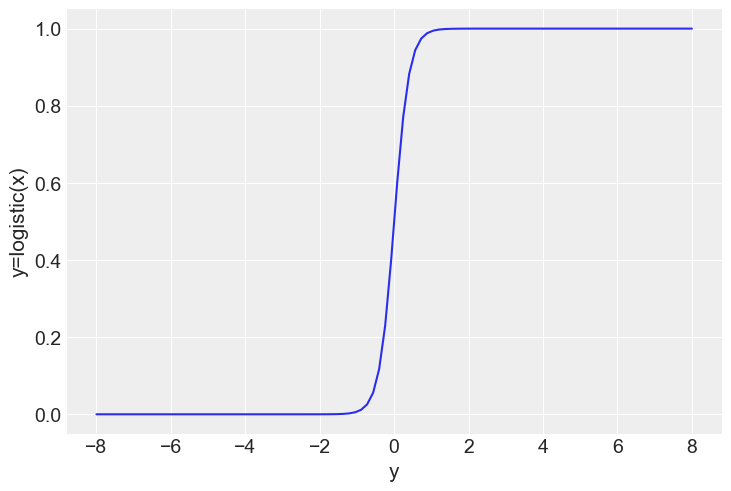

In [30]:
# A reminder of what the logistic function looks like. 
# Play with parameters a and b to see the shape of the curve change
b = 5.
x = np.linspace(-8, 8, 100)
plt.plot(x, 1 / (1 + np.exp(-b*x)))
plt.xlabel('y')
plt.ylabel('y=logistic(x)')